In [36]:
import torch
import torch.nn as nn
import functorch

import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import random
import idx2numpy  # conda install pip, then pip install idx2numpy - allows us to easily convert un gziped mnist files to numpy arrays
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm
%matplotlib inline

In [37]:
import os
os.getcwd()

'/home/bkosa2/RNP/RNP_PyTorch/Pytorch_hypernets/notebooks'

In [38]:
# Important for using GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [4]:
# hyperparams
# input_size = 784  # 28x28
# synthnet_hidden_size = 100
# num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

In [5]:
# import requests
# import gzip

In [6]:
# Probably a little extra, but here's a function that is purely meant to 
# download the MNIST dataset. If the data/mnist_data/MNIST/raw/... MNIST data
# files already exist, then just return the mnist data
# in a list format ==> [[train_images], [train_labels], [test_images], [test_labels]] 
# def download_mnist(url,file_dict=None):
#     if file_dict is not None:
#         mnist_data=list()
#         try:
#             for i, key in enumerate(file_dict.keys()):    
#                 fname = file_dict[key]
#                 url = os.path.join(url,fname)
#                 isExist = os.path.exists(fname)
#                 if not isExist:
#                     response = requests.get(url, stream=True)
#                     fsize=len(response.content)
#                     print(url)
#                     with open(fname, 'wb') as fout:
#                         for data in tqdm(response.iter_content(), desc =fname, total=fsize):
#                             fout.write(data)
                
#                 with gzip.open(fname, "rb") as f_in:                
#                     if fname.find('idx3') != -1:        
#                         mnist_data.append(np.frombuffer(f_in.read(), np.uint8, offset=16).reshape(-1, 28, 28)) #if images        
#                     else:                               
#                         mnist_data.append(np.frombuffer(f_in.read(), np.uint8, offset=8))  #if labels
#             #return mnist_data in a list format ==> [[train_images], [train_labels], [test_images], [test_labels]] 
#             return mnist_data
#         except Exception as e:
#             print("Something went wrong:", e)
#     else:
#         print("file_dict cannot be None")

In [7]:
# Load in the normal MNIST dataset into train and testing dataloaders
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data/mnist_data', 
                                                          download=True, 
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                          ])), 
                                           batch_size=batch_size, 
                                           shuffle=True)

# download and transform test dataset
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data/mnist_data', 
                                                          download=True, 
                                                          train=False,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                          ])), 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [8]:
class SeqMNISTDataset(Dataset):
    """ Custom Sequential MNIST dataset """
    def __init__(self, digit_seqs, labels, transform=None):
        """
        Args:
            digit_seqs (list): a list of
            labels (list): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.digit_seqs = digit_seqs
        self.labels = labels
        # self.transform = transform

    def __getitem__(self, idx):
        label = self.labels[idx]
        digit_seq = self.digit_seqs[idx]
        # digit_seq = self.transform(np.array(digit_seq))
        return digit_seq, label
    
    def __len__(self):
        return len(self.labels)

In [9]:
# Load the mnist dataset as numpy arrays.
train_images_path = os.path.normpath("../data/mnist_data/MNIST/raw/train-images-idx3-ubyte")
train_labels_path = os.path.normpath("../data/mnist_data/MNIST/raw/train-labels-idx1-ubyte")
test_images_path = os.path.normpath("../data/mnist_data/MNIST/raw/t10k-images-idx3-ubyte")
test_labels_path = os.path.normpath("../data/mnist_data/MNIST/raw/t10k-labels-idx1-ubyte")
train_images = idx2numpy.convert_from_file(train_images_path)
train_labels = idx2numpy.convert_from_file(train_labels_path)
test_images = idx2numpy.convert_from_file(test_images_path)
test_labels = idx2numpy.convert_from_file(test_labels_path)

In [10]:
# Create our custom mnist sequential dataset where each input
# is 5 MNIST digits in order and the corresponding label is the next digit.
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

train_zeros = train_images[train_labels == 0, :, :]
train_ones = train_images[train_labels == 1, :, :]
train_twos = train_images[train_labels == 2, :, :]
train_threes = train_images[train_labels == 3, :, :]
train_fours = train_images[train_labels == 4, :, :]
train_fives = train_images[train_labels == 5, :, :]
train_sixes = train_images[train_labels == 6, :, :]
train_sevens = train_images[train_labels == 7, :, :]
train_eights = train_images[train_labels == 8, :, :]
train_nines = train_images[train_labels == 9, :, :]
train_ordered = [train_zeros,
                 train_ones, 
                 train_twos, 
                 train_threes, 
                 train_fours, 
                 train_fives, 
                 train_sixes, 
                 train_sevens, 
                 train_eights, 
                 train_nines]

print(train_zeros.shape)
print(train_ones.shape)
print(train_twos.shape)
print(train_threes.shape)
print(train_fours.shape)
print(train_fives.shape)
print(train_sixes.shape)
print(train_sevens.shape)
print(train_eights.shape)
print(train_nines.shape)

smallest_train_set_size = min(train_zeros.shape[0], \
                        train_ones.shape[0], \
                        train_twos.shape[0], \
                        train_threes.shape[0], \
                        train_fours.shape[0], \
                        train_fives.shape[0], \
                        train_sixes.shape[0], \
                        train_sevens.shape[0], \
                        train_eights.shape[0], \
                        train_nines.shape[0])

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
(5923, 28, 28)
(6742, 28, 28)
(5958, 28, 28)
(6131, 28, 28)
(5842, 28, 28)
(5421, 28, 28)
(5918, 28, 28)
(6265, 28, 28)
(5851, 28, 28)
(5949, 28, 28)


In [11]:
# Create our custom mnist sequential dataset where each input
# is 5 MNIST digits in order and the corresponding label is the next digit.
test_zeros = test_images[test_labels == 0, :, :]
test_ones = test_images[test_labels == 1, :, :]
test_twos = test_images[test_labels == 2, :, :]
test_threes = test_images[test_labels == 3, :, :]
test_fours = test_images[test_labels == 4, :, :]
test_fives = test_images[test_labels == 5, :, :]
test_sixes = test_images[test_labels == 6, :, :]
test_sevens = test_images[test_labels == 7, :, :]
test_eights = test_images[test_labels == 8, :, :]
test_nines = test_images[test_labels == 9, :, :]
test_ordered = [test_zeros,
                 test_ones, 
                 test_twos, 
                 test_threes, 
                 test_fours, 
                 test_fives, 
                 test_sixes, 
                 test_sevens, 
                 test_eights, 
                 test_nines]

print(test_zeros.shape)
print(test_ones.shape)
print(test_twos.shape)
print(test_threes.shape)
print(test_fours.shape)
print(test_fives.shape)
print(test_sixes.shape)
print(test_sevens.shape)
print(test_eights.shape)
print(test_nines.shape)

# I plan to loop through from indices 0 - smallest_test_set_size and for every index,
# concatenate 5 sequential mnist digits. 
smallest_test_set_size = min(test_zeros.shape[0], \
                        test_ones.shape[0], \
                        test_twos.shape[0], \
                        test_threes.shape[0], \
                        test_fours.shape[0], \
                        test_fives.shape[0], \
                        test_sixes.shape[0], \
                        test_sevens.shape[0], \
                        test_eights.shape[0], \
                        test_nines.shape[0])

(980, 28, 28)
(1135, 28, 28)
(1032, 28, 28)
(1010, 28, 28)
(982, 28, 28)
(892, 28, 28)
(958, 28, 28)
(1028, 28, 28)
(974, 28, 28)
(1009, 28, 28)


In [12]:
# Create the training digit sequence samples
train_seqs = []
train_labels = []
# If this isn't enough data, then I can increase the size.
for i in range(smallest_train_set_size):
    # Each image's px values are [0, 255]. Normalize to [0, 1]
    first_digit = random.randint(0, 5)
    train_seq = []
    # Divide by 255 to normalize each mnist digit image to only have pixel values between [0, 1].
    train_seq.append(train_ordered[first_digit][i].flatten() / 255)
    train_seq.append(train_ordered[first_digit + 1][i].flatten() / 255)
    train_seq.append(train_ordered[first_digit + 2][i].flatten() / 255)
    train_seq.append(train_ordered[first_digit + 3][i].flatten() / 255)
    train_seq.append(train_ordered[first_digit + 4][i].flatten() / 255)
    train_seqs.append(train_seq)
    train_labels.append(first_digit + 5)

    # print(f"train_seq = {train_seq}")
    # print(f"train_seqs = {train_seqs}")

# plt.imshow(train_zeros[5000].reshape(28, 28), cmap='gray')

len of train_seq = 5
label for train_seq is: 5
len of train_seqs: 5421


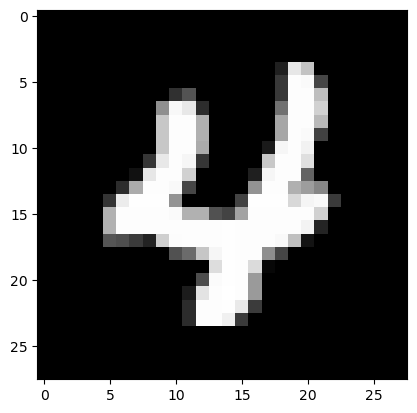

In [13]:
# Just evaluating the data to make sure it's ok
print(f"len of train_seq = {len(train_seq)}")
plt.imshow(train_seq[4].reshape(28, 28), cmap='gray')
print(f"label for train_seq is: {train_labels[-1]}")
print(f"len of train_seqs: {len(train_labels)}")

In [14]:
# Create the testing digit sequence samples
test_seqs = []
test_labels = []
for i in range(smallest_test_set_size):
    first_digit = random.randint(0, 5)
    test_seq = []
    test_seq.append(test_ordered[first_digit][i].flatten())
    test_seq.append(test_ordered[first_digit + 1][i].flatten())
    test_seq.append(test_ordered[first_digit + 2][i].flatten())
    test_seq.append(test_ordered[first_digit + 3][i].flatten())
    test_seq.append(test_ordered[first_digit + 4][i].flatten())
    test_seqs.append(test_seq)
    test_labels.append(first_digit + 5)

# plt.imshow(train_zeros[5000].reshape(28, 28), cmap='gray')

len of train_seq = 5
label for train_seq is: 8
len of train_seqs: 892


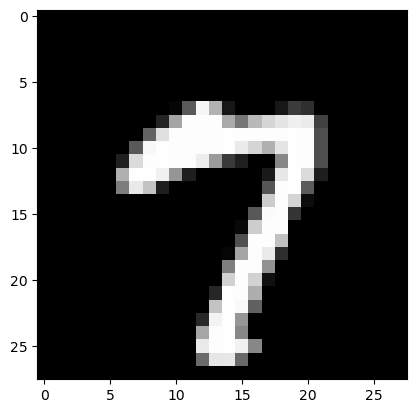

In [18]:
# Just evaluating the data to make sure it's ok
print(f"len of train_seq = {len(test_seq)}")
plt.imshow(test_seq[4].reshape(28, 28), cmap='gray')
print(f"label for train_seq is: {test_labels[-1]}")
print(f"len of train_seqs: {len(test_labels)}")

In [19]:
# Convert to tensor
train_seqs = torch.FloatTensor(np.array(train_seqs))
train_labels = torch.FloatTensor(np.array(train_labels))
test_seqs = torch.FloatTensor(np.array(test_seqs))
test_labels = torch.FloatTensor(np.array(test_labels))

In [20]:
print(f"train_seqs shape = {train_seqs.shape}")
print(f"train_labels shape = {train_labels.shape}")
print(f"test_seqs shape = {test_seqs.shape}")
print(f"test_labels shape = {test_labels.shape}")


train_seqs shape = torch.Size([5421, 5, 784])
train_labels shape = torch.Size([5421])
test_seqs shape = torch.Size([892, 5, 784])
test_labels shape = torch.Size([892])


In [42]:
# Normalize each individual image along

(28, 28, 5, 5421)


train_seqs shape = torch.Size([5421, 5, 784])
train_labels shape = torch.Size([5421])
test_seqs shape = torch.Size([892, 5, 784])
test_labels shape = torch.Size([892])


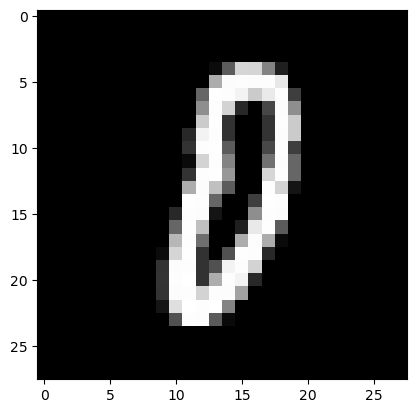

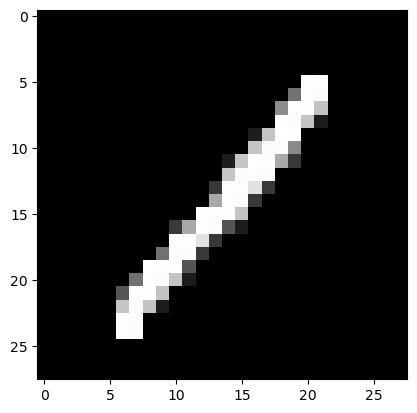

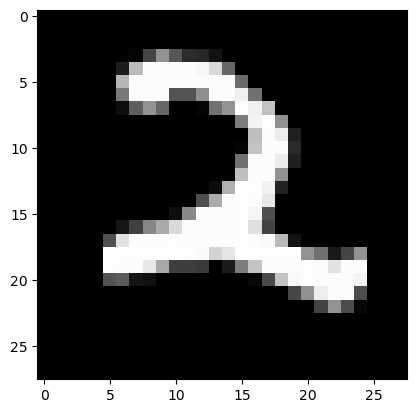

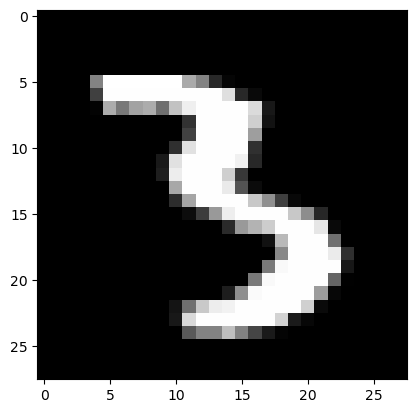

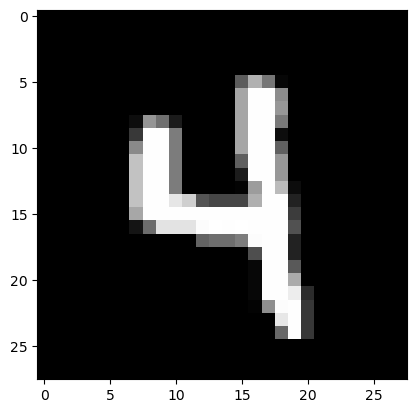

tensor(5.)


In [21]:
# Me just making sure it looks right
print(f"train_seqs shape = {train_seqs.shape}")
print(f"train_labels shape = {train_labels.shape}")
print(f"test_seqs shape = {test_seqs.shape}")
print(f"test_labels shape = {test_labels.shape}")

i = 1999
plt.imshow(train_seqs[i][0].reshape(28, 28), cmap='gray')
plt.show()
plt.imshow(train_seqs[i][1].reshape(28, 28), cmap='gray')
plt.show()
plt.imshow(train_seqs[i][2].reshape(28, 28), cmap='gray')
plt.show()
plt.imshow(train_seqs[i][3].reshape(28, 28), cmap='gray')
plt.show()
plt.imshow(train_seqs[i][4].reshape(28, 28), cmap='gray')
plt.show()
print(train_labels[i])

In [22]:
# Load our data into a DataSet and DataLoader
train_loader = torch.utils.data.DataLoader(SeqMNISTDataset(train_seqs, train_labels), 
                                           batch_size=batch_size, 
                                           shuffle=True)

# download and transform test dataset
test_loader = torch.utils.data.DataLoader(SeqMNISTDataset(test_seqs, test_labels), 
                                           batch_size=batch_size, 
                                           shuffle=True)


In [23]:
inputs, _ = next(iter(train_loader))
print(f"inputs.shape: {inputs.shape}")

inputs.shape: torch.Size([100, 5, 784])


In [24]:
class HyperNetwork(torch.nn.Module):
    def __init__(self, hypnet: torch.nn.Module, synthnet: torch.nn.Module):
        # hypnet is the network that takes an embedding z and produces the parameters of synthnet
        # synthnet is the network that takes input x and produces h
        super().__init__()
        s_func, s_params0 = functorch.make_functional(synthnet)

        # store the information about the parameters
        self._sp_shapes = [sp.shape for sp in s_params0]

        # These are the index offsets for each parameter (e.g. set of weights between
        # each layer and set of biases for each layer)
        self._sp_offsets = np.array([0, *np.cumsum([sp.numel() for sp in s_params0])])

        # make the synthnet_func to accept batched parameters
        synthnet_func = functorch.vmap(s_func)
        # a workaround of functorch's bug #793
        # self._synthnet_batched_func = [synthnet_func]
        self._synthnet_batched_func = synthnet_func
        self._hypnet = hypnet

    def forward(self, x: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        # x: (batch_size, nx), z: (batch_size, nz)
        params = self._hypnet(z)  # params: (batch_size, nparams_tot)

        # rearrange params to have the same shape as the synthnet params, except on the batch dimension
        # print(f"self._sp_offsets: {self._sp_offsets}")
        params_lst = []
        for i, shape in enumerate(self._sp_shapes):
            j0, j1 = self._sp_offsets[i], self._sp_offsets[i + 1]
            params_lst.append(params[..., j0:j1].reshape(-1, *shape))

        # print(f"params_lst: {params_lst}")

        # apply the function to the batched parameters and x
        h = self._synthnet_batched_func(params_lst, x)
        return h
        # return params_lst

In [25]:
# Encoder for Feed Forward Network
class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return encoded

In [26]:
class RNNEncoder(nn.Module):
    def __init__(self, input_size, hidden_dim, n_layers):
        super(RNNEncoder, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True).cuda()
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size).cuda()

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        return hidden  # Our final hidden state is a summary (or encoding) of the whole input sequence.
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [ ]:
# class RNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(RNN, self).__init__()

#         self.hidden_size = hidden_size

#         self.i2h = torch.nn.Linear(input_size + hidden_size, hidden_size)
#         self.i2o = torch.nn.Linear(input_size + hidden_size, output_size)
#         self.softmax = torch.nn.LogSoftmax(dim=1)

#     def forward(self, input, hidden):
#         combined = torch.cat((input, hidden), 1)
#         hidden = self.i2h(combined)
#         output = self.i2o(combined)
#         output = self.softmax(output)
#         return output, hidden

In [27]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()

        # Number of hidden dims
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Init hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[: ,-1, :])
        return out

In [66]:
# np.array([0, *np.cumsum([sp.numel() for sp in a])])

In [8]:
synthnet = torch.nn.Sequential(
    torch.nn.Linear(28*28, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10),
).to(device)

In [28]:
# Using an RNN as a synthnet
input_dim = 28 * 28    # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 10   # output dimension

synthnet_rnn = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

In [29]:
# Synthnet params for simple feed forward nn
_, synthnet_params = functorch.make_functional(synthnet)
n_synthnet_params = sum([p.numel() for p in synthnet_params])

NameError: name 'synthnet' is not defined

In [52]:
# Ben's Code - Just me peeking inside the synthnet_params for feed forward synthnet to understand what PyTorch Module params actually are under the hood. synthnet is just a nn with 1 hidden layer.
print(len(synthnet_params))
print(synthnet_params[0].size())  # The weights for the connections from input layer (784 units) to hidden layer (100 units)
print(synthnet_params[1].size())  # The biases for each of the 100 units in the hidden layer???
print(synthnet_params[2].size())  # The weights for the connections from the hidden layer (100 units) to the output layer (10 units)
print(synthnet_params[3].size())  # The biases for each of the 10 units in the output layer???
print(n_synthnet_params)

6
torch.Size([100, 784])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100])
89610


In [30]:
# Params for RNN synthnet
_, synthnet_params = functorch.make_functional(synthnet_rnn)
n_synthnet_params = sum([p.numel() for p in synthnet_params])

In [31]:
# Ben's Code - Just me peeking inside the synthnet_params to understand what PyTorch Module params actually are under the hood. 
# synthnet_rnn is just an RNN with 1 hidden layer with 100 units.
print(len(synthnet_params))
print(synthnet_params[0].size())  # W_ih (28 x 100)
print(synthnet_params[1].size())  # W_hh (100 x 100)
print(synthnet_params[2].size())  # b_ih[0], where k is the ith layer
print(synthnet_params[3].size())  # b_hh[0]
print(synthnet_params[4].size())  # W_ho
print(synthnet_params[5].size())  # b_o
print(n_synthnet_params)

6
torch.Size([100, 784])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])
89610


In [42]:
hypnet = torch.nn.Sequential(
    torch.nn.Linear(9, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, n_synthnet_params),
).to(device)

In [43]:
module = HyperNetwork(hypnet, synthnet_rnn).to(device)
encoder = RNNEncoder(28 * 28, 9, 1).to(device)

In [ ]:
# Just for Ben to run one iteraiton of hypernet forward func to see what's going on
# under the hood.
inputs, _ = next(iter(train_loader))
inputs = inputs.view(-1, 28*28).to(device)
z = encoder(inputs).to(device)
module(inputs, z)

In [73]:
# This is for if you want to test out our HyperNet pipeline with a random input embedding z (that is not generated from an encoder)
# z = torch.randn(32, 3)
# x, y = next(iter(test_loader))

In [44]:
criterion = torch.nn.CrossEntropyLoss()

In [45]:
optimizer = torch.optim.Adam([*module.parameters(), *encoder.parameters()], lr=learning_rate)

In [46]:
# Important for using GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [47]:
for epoch in range(num_epochs):  # loop over the dataset num_epochs times
    running_loss = 0.0
    i = 0  # Just keeps track of which batch we're on until we get to batch 500, in which case we print
           # out the aggregated loss over the 500 batches and reset (i.e. allows us to just print out the
           # average loss every 500 batches instead of every batch)
    for inputs, labels in tqdm(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.view(-1, 5, 28*28).to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        z = encoder(inputs).to(device)

        # forward + backward + optimize
        # outputs = module(inputs, weights).reshape(-1, 10)
        outputs = module(inputs, z).reshape(-1, 10)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        i += 1
        if i % 100 == 0:    # print every 500 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

  0%|          | 0/55 [00:00<?, ?it/s]


RuntimeError: For unbatched 2-D input, hx should also be 2-D but got 3-D tensor

In [25]:
# Test the accuracy of our trained model
# In test phase, we don't need to compute gradients (for memory efficiency)
def calc_accuracy(test_loader):
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            z = encoder(images).to(device)
            outputs = module(images, z).reshape(-1, 10)
            # max returns (value ,index)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        acc = 100.0 * n_correct / n_samples
        return acc

In [26]:
calc_accuracy(test_loader)

96.99